In [1]:
from keras.models import load_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

Using TensorFlow backend.


In [2]:
import nltk
from nltk.util import ngrams
import spacy 
import numpy
import pandas as pd
import seaborn as sns

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
#spacy.__path__

In [4]:
#%%time
#nlp=spacy.load('en_vectors_web_lg')
%time nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')
%time model=load_model('./model/lstm.h5')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 47.9 s, sys: 10.9 s, total: 58.8 s
Wall time: 58.8 s
CPU times: user 19.3 s, sys: 2min 10s, total: 2min 30s
Wall time: 2min 22s


In [5]:
def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [6]:
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('./model/classes.npy')

### write code for n gram

In [37]:
!grep -rn validation_lines *.ipynb 

exportValidation.ipynb:45:    "with open('./Data/validation_lines.txt','w')as f:\n",
exportValidation.ipynb:55:    "#!echo $PWD/Data/validation_lines.txt"
nGramClassification_batch.ipynb:138:    "with open('./Data/validation_lines.txt') as f:\n",


In [7]:
with open('./Data/validation_lines.txt') as f:
    lines=f.readlines()

In [35]:
#!head ./Data/validation_lines.txt

The role of viruses in human diabetes.
Wastewater reclamation for use in snow-making within an alpine resort in Australia--resource rather than waste.
Selection for mutants improving expression of an anti-MAP kinase monoclonal antibody by filamentous phage display.
Autonomic failure mimicing dopamine agonist induced vertigo in a patient with macroprolactinoma.
PTP-PEST controls motility through regulation of Rac1.
Impaired antibody-dependent cellular cytotoxicity mediated by herceptin in patients with gastric cancer.
The shape of the messenger: using protein structure information to design novel cytokine-based therapeutics.
[Seroprevalence of hepatitis A].
Perceived odor and irritation of isopropanol: a comparison between na ve controls and occupationally exposed workers.
Drug specific resistance to oxaliplatin is associated with apoptosis defect in a cellular model of colon carcinoma.


In [8]:
print ("out dir: ",os.getcwd()+'/Data/hmaps_batch/')

out dir:  /data/cellardata/users/btsui/DEEP_NLP/NLP_spacy/Data/hmaps_batch/


  0%|          | 0/100 [00:00<?, ?it/s]


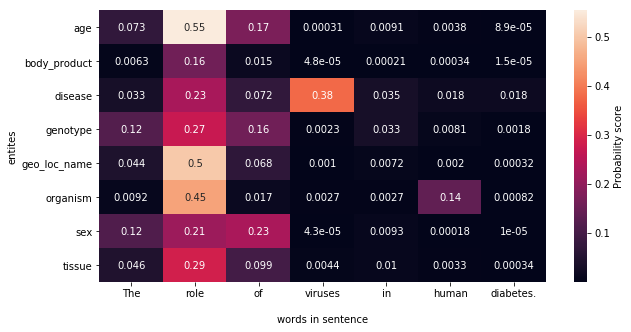

In [9]:
#sent='Large outbreak of pre-XDR TB Argentina'
for i_line,sent in enumerate(tqdm(lines)):

    tokens=sent.split(' ')
    s=sent.split(' ')

    scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
    #for n_gram in range(1,len(tokens)+1):
    for n_gram in range(1,len(tokens)):
        grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
        #print (grams)
        val_docs = list(nlp.pipe(grams))
        val_X=get_features(val_docs,max_length=model.input_shape[1])
        tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
        """
        each n gram only advange 
        """
        for i,gram in enumerate(tmpDf.index):# for ec
            for j,one_gram in enumerate(gram.split(' ')):
                scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
                
    displayHmap=scoreDf.T
    fig,ax=plt.subplots(figsize=(10,5))
    #displayHmap[displayHmap.max(axis=1)<0.5]=0
    sns.heatmap(data=displayHmap,ax=ax,cbar_kws={'label':'Probability score'},annot=True)
    ax.set_ylabel('entites')
    ax.set_xlabel('words in sentence')
    fig.savefig('./Data/hmaps_batch/{}.pdf'.format(i_line),bbox_inches='tight')
    break
    plt.clf()

In [17]:
lines[2]

'Selection for mutants improving expression of an anti-MAP kinase monoclonal antibody by filamentous phage display.\n'

In [27]:
docs=nlp.pipe(['TP53'])

In [28]:
for doc in docs:
    break

In [15]:
import re
re.sub(r'\W+', '', your_string)


pooled skeletal muscle tissue miRNA from 3
pooled skeletal muscle tissue miRNA from 3
['pooled', 'skeletal', 'muscle', 'tissue', 'miRNA', 'from', '3']


Text(0.5,24,'words in sentence')

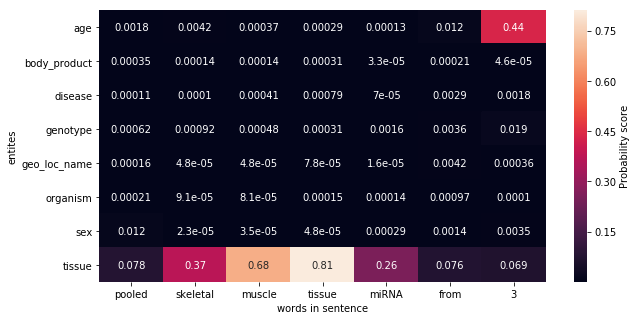

In [56]:
sent='pooled skeletal muscle tissue miRNA from 3'#lines[10]
#sent=sent.replace('.\n','')
print (sent)

sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
for n_gram in range(1,len(tokens)):
    grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
    #print (grams)
    val_docs = list(nlp.pipe(grams))
    val_X=get_features(val_docs,max_length=model.input_shape[1])
    tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
    """
    each n gram only advange 
    """
    for i,gram in enumerate(tmpDf.index):# for ec
        for j,one_gram in enumerate(gram.split(' ')):
            scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))

displayHmap=scoreDf.T
fig,ax=plt.subplots(figsize=(10,5))
#displayHmap[displayHmap.max(axis=1)<0.5]=0
sns.heatmap(data=displayHmap,ax=ax,cbar_kws={'label':'Probability score'},annot=True)
ax.set_ylabel('entites')
ax.set_xlabel('words in sentence')


In [57]:
### among the ones with clear boundry, it can classify well. 


"""
argue that it can salvage the data correctly. Among those sentences, 

take >0.5 as boundary, run top 10000 sentences 
"""
scoreDf

,age,body_product,disease,genotype,geo_loc_name,organism,sex,tissue
pooled,0.001772,0.000350,0.000110,0.000618,0.000159,0.000212,0.012014,0.078356
skeletal,0.004168,0.000141,0.000100,0.000921,0.000048,0.000091,0.000023,0.373703
muscle,0.000369,0.000141,0.000407,0.000480,0.000048,0.000081,0.000035,0.684653
tissue,0.000295,0.000310,0.000795,0.000309,0.000078,0.000153,0.000048,0.812128
miRNA,0.000132,0.000033,0.000070,0.001567,0.000016,0.000142,0.000288,0.255772
from,0.012493,0.000215,0.002889,0.003568,0.004240,0.000971,0.001397,0.075709
3,0.435250,0.000046,0.001783,0.018663,0.000359,0.000100,0.003497,0.068826
